<a href="https://colab.research.google.com/github/sudo-Oliver/Predictive-Analytics-Private/blob/main/notebooks/LSTM%20Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Daten laden und vorbereiten**
1. Laden der Daten in einen Dataframe
2. Zeitspalte umwandeln (Unix-Timestamp -> Datetime)
3. nach homeid gruppieren (jeder Haushalt hat seine eigene Zeitreihe)
4. Sortieren nach Zeit innerhalb des Haushalts

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import gdown
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
from joblib import dump, load
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Verify GPU availability
print("TensorFlow version:", tf.__version__)
print("Metal plugin available:", tf.config.list_physical_devices('GPU'))

# Configure memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    print("Metal GPU will be used")
else:
    print("Running on CPU")

TensorFlow version: 2.16.2
Metal plugin available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Metal GPU will be used


In [4]:
# def clean_data(df):
#     """Clean and preprocess sensor data"""
#     # Convert Unix timestamp to datetime
#     df['timestamp_local'] = pd.to_datetime(df['timestamp_local'], unit='ms')

#     # Set timestamp_local as index
#     df.set_index('timestamp_local', inplace=True)

#     # Sort by homeid and timestamp_local
#     df = df.sort_values(by=['homeid', 'timestamp_local'])

#     # Remove specified columns
#     columns_to_drop = [
#         'sensorid', 'median_temperature', '_room',
#         'sensorid_room', 'measured_entity',
#         'sensorid_electric', 'sensorid_gas'
#     ]
#     df = df.drop(columns=columns_to_drop)

#     return df

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
from joblib import dump, load
import gdown

def load_processed_data():
    """Load preprocessed sensor data with fallback to Drive download"""
    file_id = "1KHQCVfwTxm5bjjITS8WMm9P3M12ETVsR"
    
    download_path = Path('data/processed')
    download_path.mkdir(parents=True, exist_ok=True)
    file_path = download_path / 'final_processed_data3.parquet'
    
    if not file_path.exists():
        print("Downloading from Google Drive...")
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, str(file_path), quiet=False)
    
    if file_path.exists():
        df = pd.read_parquet(file_path)
        print(f"Data loaded successfully: {df.shape} rows")
        return df
    else:
        raise FileNotFoundError("Could not load or download data file")

def clean_data(df):
    """Clean and preprocess sensor data"""
    # Convert Unix timestamp to datetime if needed
    if 'timestamp_local' in df.columns:
        df['timestamp_local'] = pd.to_datetime(df['timestamp_local'], unit='ms')
        # Sort before setting index
        df = df.sort_values(by=['homeid', 'timestamp_local'])
        # Then set index
        df.set_index('timestamp_local', inplace=True)
    
    # Remove unnecessary columns
    columns_to_drop = [
        'sensorid', 'median_temperature', '_room',
        'sensorid_room', 'measured_entity',
        'sensorid_electric', 'sensorid_gas'
    ]
    
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    # First rename consumption columns from Wh to kWh
    df = df.rename(columns={
        'electric_total_consumption_Wh': 'electric_total_consumption_kWh',
        'gas_total_consumption_Wh': 'gas_total_consumption_kWh'
    })
    
    # Replace negative values with 0 in gas columns
    gas_columns = [
        'gas_mean_consumption', 
        'gas_min_consumption', 
        'gas_max_consumption',
        'gas_median_consumption', 
        'gas_total_consumption_kWh'
    ]
    
    # Use clip to replace negative values with 0 (more efficient than applymap)
    df[gas_columns] = df[gas_columns].clip(lower=0)
    
    return df

def create_features(df, df_original):
    """Create time-based and lag features"""
    # Verify datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have DatetimeIndex")
    
    # Cyclical time features
    df['hour'] = df.index.hour
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    # Lag features using original values
    for lag in range(1, 4):
        df[f'electric_lag_{lag}'] = df_original.groupby('homeid')['electric_total_consumption_kWh'].shift(lag)
        df[f'gas_lag_{lag}'] = df_original.groupby('homeid')['gas_total_consumption_kWh'].shift(lag)
    
    # Rolling means using original values
    df['electric_rolling_mean_3h'] = df_original.groupby('homeid')['electric_total_consumption_kWh'].rolling(window=3).mean().reset_index(0, drop=True)
    df['electric_rolling_mean_7h'] = df_original.groupby('homeid')['electric_total_consumption_kWh'].rolling(window=7).mean().reset_index(0, drop=True)
    df['gas_rolling_mean_3h'] = df_original.groupby('homeid')['gas_total_consumption_kWh'].rolling(window=3).mean().reset_index(0, drop=True)
    df['gas_rolling_mean_7h'] = df_original.groupby('homeid')['gas_total_consumption_kWh'].rolling(window=7).mean().reset_index(0, drop=True)
    
    return df

# Main preprocessing pipeline
print("Loading data...")
df = load_processed_data()

print("\nCleaning data...")
df_clean = clean_data(df.copy())
df_original = df_clean.copy()  # Keep unmodified copy for feature creation

print("\nCreating features...")
df_clean = create_features(df_clean, df_original)

print("Handling missing values...")
df_clean = df_clean.ffill().bfill()

# Verify data
print("\nData shape after preprocessing:", df_clean.shape)
print("Index type:", type(df_clean.index))
print("Feature columns:", df_clean.columns.tolist())

df_clean.head()

Loading data...
Data loaded successfully: (1641653, 23) rows

Cleaning data...

Creating features...
Handling missing values...

Data shape after preprocessing: (1641653, 28)
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Feature columns: ['homeid', 'electric_min_consumption', 'electric_max_consumption', 'std_consumption', 'electric_median_consumption', 'electric_total_consumption_kWh', 'gas_mean_consumption', 'gas_min_consumption', 'gas_max_consumption', 'gas_median_consumption', 'gas_total_consumption_kWh', 'median_value', 'roomid', 'income_band_mid', 'education_map', 'hour', 'hour_sin', 'hour_cos', 'electric_lag_1', 'gas_lag_1', 'electric_lag_2', 'gas_lag_2', 'electric_lag_3', 'gas_lag_3', 'electric_rolling_mean_3h', 'electric_rolling_mean_7h', 'gas_rolling_mean_3h', 'gas_rolling_mean_7h']


,homeid,electric_min_consumption,electric_max_consumption,std_consumption,electric_median_consumption,electric_total_consumption_kWh,gas_mean_consumption,gas_min_consumption,gas_max_consumption,gas_median_consumption,...,electric_lag_1,gas_lag_1,electric_lag_2,gas_lag_2,electric_lag_3,gas_lag_3,electric_rolling_mean_3h,electric_rolling_mean_7h,gas_rolling_mean_3h,gas_rolling_mean_7h
timestamp_local,,,,,,,,,,,,,,,,,,,,,
2016-09-20 09:00:00,47,0.069000,0.335000,0.033905,0.194000,0.179807,0.112,0.112,0.112,0.112,...,0.179807,0.224,0.179807,0.224,0.179807,0.224,0.176690,0.170457,0.210,0.182
2016-09-20 10:00:00,47,0.068875,0.458375,0.035875,0.187625,0.176690,0.112,0.112,0.112,0.112,...,0.179807,0.224,0.179807,0.224,0.179807,0.224,0.176690,0.170457,0.210,0.182
2016-09-20 11:00:00,47,0.068750,0.581750,0.037846,0.181250,0.173574,0.112,0.112,0.112,0.112,...,0.176690,0.210,0.179807,0.224,0.179807,0.224,0.176690,0.170457,0.210,0.182
2016-09-20 12:00:00,47,0.068625,0.705125,0.039817,0.174875,0.170457,0.112,0.112,0.112,0.112,...,0.173574,0.196,0.176690,0.210,0.179807,0.224,0.173574,0.170457,0.196,0.182
2016-09-20 13:00:00,47,0.068500,0.828500,0.041788,0.168500,0.167340,0.112,0.112,0.112,0.112,...,0.170457,0.182,0.173574,0.196,0.176690,0.210,0.170457,0.170457,0.182,0.182


In [6]:
# import pandas as pd
# import numpy as np
# from pathlib import Path
# from joblib import dump, load
# import gdown

# def load_processed_data():
#     """Load preprocessed sensor data with fallback to Drive download"""
#     file_id = "1KHQCVfwTxm5bjjITS8WMm9P3M12ETVsR"
    
#     download_path = Path('data/processed')
#     download_path.mkdir(parents=True, exist_ok=True)
#     file_path = download_path / 'final_processed_data3.parquet'
    
#     if not file_path.exists():
#         print("Downloading from Google Drive...")
#         url = f"https://drive.google.com/uc?id={file_id}"
#         gdown.download(url, str(file_path), quiet=False)
    
#     if file_path.exists():
#         df = pd.read_parquet(file_path)
#         print(f"Data loaded successfully: {df.shape} rows")
#         return df
#     else:
#         raise FileNotFoundError("Could not load or download data file")

# def create_features(df, df_original):
#     """Create time-based and lag features"""
#     # Cyclical time features
#     df['hour'] = df.index.hour
#     df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
#     df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
#     # Lag features using original values
#     for lag in range(1, 4):
#         df[f'electric_lag_{lag}'] = df_original.groupby('homeid')['electric_total_consumption_kWh'].shift(lag)
#         df[f'gas_lag_{lag}'] = df_original.groupby('homeid')['gas_total_consumption_kWh'].shift(lag)
    
#     # Rolling means using original values
#     df['electric_rolling_mean_3h'] = df_original.groupby('homeid')['electric_total_consumption_kWh'].rolling(window=3).mean().reset_index(0, drop=True)
#     df['electric_rolling_mean_7h'] = df_original.groupby('homeid')['electric_total_consumption_kWh'].rolling(window=7).mean().reset_index(0, drop=True)
#     df['gas_rolling_mean_3h'] = df_original.groupby('homeid')['gas_total_consumption_kWh'].rolling(window=3).mean().reset_index(0, drop=True)
#     df['gas_rolling_mean_7h'] = df_original.groupby('homeid')['gas_total_consumption_kWh'].rolling(window=7).mean().reset_index(0, drop=True)
    
#     return df

# # Load data and create copies
# print("Loading data...")
# df = load_processed_data()
# df_clean = df.copy()
# df_original = df.copy()  # Keep unmodified copy for feature creation

# # Create features
# print("\nCreating features...")
# df_clean = create_features(df_clean, df_original)

# # Handle missing values
# print("Handling missing values...")
# df_clean = df_clean.ffill().bfill()

# # Verify data
# print("\nData shape after preprocessing:", df_clean.shape)
# print("\nFeature columns:", df_clean.columns.tolist())

In [4]:
# Vollständige Korrelation mit allen spalten berechnen
correlation_matrix_all = df_clean.corr()

# Korrelation der Features mit den Zielvariablen (Strom und Gasverbtauch)
correlation_target_all = correlation_matrix_all[['electric_total_consumption_kWh', 'gas_total_consumption_kWh']]

# Sortieren nach Stärke der Korrelation
correlation_target_all_sorted = correlation_target_all.abs().sort_values(by=['electric_total_consumption_kWh', 'gas_total_consumption_kWh'], ascending=False)

# Korrelationsergebnisse anzeigen
print("Full Feature Correlation:")
display(correlation_target_all_sorted)

Full Feature Correlation:


,electric_total_consumption_kWh,gas_total_consumption_kWh
electric_total_consumption_kWh,1.000000,0.032211
electric_rolling_mean_3h,0.910031,0.033895
electric_lag_1,0.815291,0.031146
electric_median_consumption,0.803903,0.025041
electric_rolling_mean_7h,0.795197,0.035802
std_consumption,0.775032,0.024053
electric_lag_2,0.705972,0.030551
electric_max_consumption,0.693017,0.042800
electric_lag_3,0.629546,0.030036
electric_min_consumption,0.516674,0.039670


### 2.Feature Engineering & Scaling ### 


In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from pathlib import Path

# Create scalers directory
Path('scalers').mkdir(parents=True, exist_ok=True)

# Store original unscaled data
df_original = df_clean.copy()

# Extract hour and create cyclical features
df_clean['hour'] = df_clean.index.hour
df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['hour'] / 24)
df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['hour'] / 24)

# Create lag features using original values
for lag in range(1, 4):
    df_clean[f'electric_lag_{lag}'] = df_original.groupby('homeid')['electric_total_consumption_kWh'].shift(lag)
    df_clean[f'gas_lag_{lag}'] = df_original.groupby('homeid')['gas_total_consumption_kWh'].shift(lag)

# Create rolling means using original values
df_clean['electric_rolling_mean_3h'] = df_original.groupby('homeid')['electric_total_consumption_kWh'].rolling(window=3).mean().reset_index(0, drop=True)
df_clean['electric_rolling_mean_7h'] = df_original.groupby('homeid')['electric_total_consumption_kWh'].rolling(window=7).mean().reset_index(0, drop=True)
df_clean['gas_rolling_mean_3h'] = df_original.groupby('homeid')['gas_total_consumption_kWh'].rolling(window=3).mean().reset_index(0, drop=True)
df_clean['gas_rolling_mean_7h'] = df_original.groupby('homeid')['gas_total_consumption_kWh'].rolling(window=7).mean().reset_index(0, drop=True)

# Handle missing values
df_clean = df_clean.ffill().bfill()

# Get original min/max values from unscaled data
scaling_params = {
    "electric_mean": df_original["electric_total_consumption_kWh"].mean(),
    "electric_std": df_original["electric_total_consumption_kWh"].std(),
    "gas_mean": df_original["gas_total_consumption_kWh"].mean(),
    "gas_std": df_original["gas_total_consumption_kWh"].std(),
}

print("\nOriginal values before scaling:")
for key, value in scaling_params.items():
    print(f"{key}: {value:.4f}")

# Initialize scalers
scaler_features = StandardScaler()
scaler_electric = StandardScaler()
scaler_gas = StandardScaler()

# Scale features (excluding target variables)
feature_columns = [col for col in df_clean.columns if col not in [
    'electric_total_consumption_kWh', 
    'gas_total_consumption_kWh', 
    'homeid', 
    'hour'
]]

print(feature_columns)
print(len(feature_columns))

df_clean[feature_columns] = scaler_features.fit_transform(df_clean[feature_columns])

# Scale target variables using original data
df_clean['electric_total_consumption_kWh'] = scaler_electric.fit_transform(
    df_original[['electric_total_consumption_kWh']]
)
df_clean['gas_total_consumption_kWh'] = scaler_gas.fit_transform(
    df_original[['gas_total_consumption_kWh']]
)

# Save scalers
dump(scaler_features, 'scalers/scaler_features.pkl')
dump(df_clean['electric_total_consumption_kWh'], 'scalers/scaler_electric.pkl')
dump(df_clean['gas_total_consumption_kWh'], 'scalers/scaler_gas.pkl')
dump(scaling_params, 'scalers/scaling_params.pkl')  # Save mean and std for later inverse transformation

# Verify scaling with mean and standard deviation
print("\nVerifying scalers:")
for name, scaler in [('Electric', scaler_electric), ('Gas', scaler_gas)]:
    print(f"\n{name} scaler:")
    print(f"Mean: {scaler.mean_[0]:.6f}")
    print(f"Standard deviation: {scaler.scale_[0]:.6f}")

# Save preprocessed data
# df_clean.to_parquet('lstm_preprocessed_data.parquet')



Original values before scaling:
electric_mean: 0.4986
electric_std: 0.4750
gas_mean: 13.3070
gas_std: 98.2659
['electric_min_consumption', 'electric_max_consumption', 'std_consumption', 'electric_median_consumption', 'gas_mean_consumption', 'gas_min_consumption', 'gas_max_consumption', 'gas_median_consumption', 'median_value', 'roomid', 'income_band_mid', 'education_map', 'hour_sin', 'hour_cos', 'electric_lag_1', 'gas_lag_1', 'electric_lag_2', 'gas_lag_2', 'electric_lag_3', 'gas_lag_3', 'electric_rolling_mean_3h', 'electric_rolling_mean_7h', 'gas_rolling_mean_3h', 'gas_rolling_mean_7h']
24

Verifying scalers:

Electric scaler:
Mean: 0.498573
Standard deviation: 0.475012

Gas scaler:
Mean: 13.307014
Standard deviation: 98.265865


### 3. Trainings und Testdatensätze erstellen ###
Erstellung von X & y für das LSTM:
- time_steps = 90 (Vergangene 90 Werte werden für Vorhersagen genutzt)
- create_memmap_array() nutzt Memory-Mapped-Files → Speicheroptimierung
- process_data_efficiently() verarbeitet die Daten in Chunks → verhindert RAM-Überlastung
- Zielwerte (y) korrekt gesetzt auf die nächsten 90 Schritte

Train-Test-Split (80%-20%):
- Kein Shuffle, damit die Zeitreihenstruktur erhalten bleibt.
- Saubere Trennung für beide Zielvariablen (electric_total_consumption_kWh & gas_total_consumption_kWh).
- Finale Shapes werden überprüft und ausgegeben.

In [6]:
# Define parameters and columns
time_steps = 90

# Features and target definition (Strom und Gas)
feature_columns = [col for col in df_clean.columns if col not in ['electric_total_consumption_kWh', 'gas_total_consumption_kWh', 'homeid', 'roomid']]
target_column_electric = 'electric_total_consumption_kWh'
target_column_gas = 'gas_total_consumption_kWh'

def create_memmap_array(shape, filename, dtype='float32'):
    """Create memory-mapped array"""
    path = Path('temp_arrays')
    path.mkdir(exist_ok=True)
    return np.memmap(path / filename, dtype=dtype, mode='w+', shape=shape)

def process_data_efficiently(df_clean, target_column, feature_columns, time_steps, prefix):
    """Process data with disk-based storage"""
    total_sequences = len(df_clean) - time_steps
    n_features = len(feature_columns)
    
    # Create memory-mapped arrays
    X = create_memmap_array((total_sequences, time_steps, n_features), f'{prefix}_X.mmap')
    y = create_memmap_array((total_sequences,), f'{prefix}_y.mmap')
    
    # Process in smaller chunks
    chunk_size = 500
    feature_data = df_clean[feature_columns].values
    target_data = df_clean[target_column].values
    
    print(f"Processing {prefix} data...")
    for chunk_start in range(0, total_sequences, chunk_size):
        chunk_end = min(chunk_start + chunk_size, total_sequences)
        
        for i in range(chunk_start, chunk_end):
            X[i] = feature_data[i:i + time_steps]
            y[i] = target_data[i + time_steps]
            
        if chunk_start % (chunk_size * 10) == 0:
            print(f"Progress: {chunk_start/total_sequences*100:.1f}%")
    
    return X, y

# Process both electric and gas data
time_steps = 90
feature_columns = [col for col in df_clean.columns if col not in 
                  ['electric_total_consumption_kWh', 'gas_total_consumption_kWh', 'homeid', 'roomid']]

# Process electric data
X_electric, y_electric = process_data_efficiently(
    df_clean, 
    'electric_total_consumption_kWh',
    feature_columns,
    time_steps,
    'electric'
)

# Process gas data
# X_gas, y_gas = process_data_efficiently(
#     df_clean,
#     'gas_total_consumption_kWh',
#     feature_columns,
#     time_steps,
#     'gas'
# )

# # Split datasets
X_train_electric, X_test_electric, y_train_electric, y_test_electric = train_test_split(
    X_electric, y_electric, test_size=0.2, shuffle=False
)

# X_train_gas, X_test_gas, y_train_gas, y_test_gas = train_test_split(
#     X_gas, y_gas, test_size=0.2, shuffle=False
# )

# Prüfen, wie viele Haushalte im Trainings- und Testset enthalten sind
# train_households_gas = df_clean.loc[df_clean.index[-len(y_train_gas):], 'homeid'].nunique()
# test_households_gas = df_clean.loc[df_clean.index[-len(y_test_gas):], 'homeid'].nunique()

# print(f" Haushalte im Training (Gas): {train_households_gas}")
# print(f" Haushalte im Test (Gas): {test_households_gas}")
# print(f" Verlust an Haushalten: {254 - test_households_gas}")

train_households_electric  = df_clean.loc[df_clean.index[-len(y_train_electric):], 'homeid'].nunique()
test_households_electric  = df_clean.loc[df_clean.index[-len(y_test_electric):], 'homeid'].nunique()

print(f" Haushalte im Training (Electric)): {train_households_electric }")
print(f" Haushalte im Test (Electric ): {test_households_electric }")
print(f" Verlust an Haushalten: {254 - test_households_electric }")




# Show shapes of the data
train_test_summary = {
    'X_train_electric': X_train_electric.shape,
    'X_test_electric': X_test_electric.shape,
    # 'X_train_gas': X_train_gas.shape,
    # 'X_test_gas': X_test_gas.shape,
}
train_test_summary




Processing electric data...
Progress: 0.0%
Progress: 0.3%
Progress: 0.6%
Progress: 0.9%
Progress: 1.2%
Progress: 1.5%
Progress: 1.8%
Progress: 2.1%
Progress: 2.4%
Progress: 2.7%
Progress: 3.0%
Progress: 3.4%
Progress: 3.7%
Progress: 4.0%
Progress: 4.3%
Progress: 4.6%
Progress: 4.9%
Progress: 5.2%
Progress: 5.5%
Progress: 5.8%
Progress: 6.1%
Progress: 6.4%
Progress: 6.7%
Progress: 7.0%
Progress: 7.3%
Progress: 7.6%
Progress: 7.9%
Progress: 8.2%
Progress: 8.5%
Progress: 8.8%
Progress: 9.1%
Progress: 9.4%
Progress: 9.7%
Progress: 10.1%
Progress: 10.4%
Progress: 10.7%
Progress: 11.0%
Progress: 11.3%
Progress: 11.6%
Progress: 11.9%
Progress: 12.2%
Progress: 12.5%
Progress: 12.8%
Progress: 13.1%
Progress: 13.4%
Progress: 13.7%
Progress: 14.0%
Progress: 14.3%
Progress: 14.6%
Progress: 14.9%
Progress: 15.2%
Progress: 15.5%
Progress: 15.8%
Progress: 16.1%
Progress: 16.4%
Progress: 16.8%
Progress: 17.1%
Progress: 17.4%
Progress: 17.7%
Progress: 18.0%
Progress: 18.3%
Progress: 18.6%
Progress: 18.

{'X_train_electric': (1313250, 90, 24), 'X_test_electric': (328313, 90, 24)}

**4. LSTM Modell erstellen**
1. Daten in das LSTM Format bringen (X_train, y_train)
2. LSTM schichten definieren (Tensorflow)
3. Modell kompilieren und trainieren
4. Hyperparameter-Tuning (z.B Anzahl Neuronen, Learning Rate,...)

**The LSTM Architecture**

In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Add dropout parameter to LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0  # Only apply dropout with multiple layers
        )
        
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

**The LSTM Training**

In [8]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm
import os

# Check and configure MPS device for M2 Mac
has_mps = torch.backends.mps.is_available()
if has_mps:
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("MPS device not found, using CPU")

# Improved data preparation with explicit float32
def prepare_data_for_training(X, y, batch_size=16):
    """Convert numpy arrays to PyTorch DataLoader with float32 precision"""
    X_tensor = torch.FloatTensor(X).to(torch.float32)
    y_tensor = torch.FloatTensor(y).reshape(-1, 1).to(torch.float32)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Early stopping handler
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Improved training function with early stopping
def train_model(model, train_loader, model_name, num_epochs=10):
    """Train model with early stopping and checkpoint saving for each epoch"""
    checkpoint_dir = 'checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    early_stopping = EarlyStopping(patience=2)
    best_loss = float('inf')

    epoch_pbar = tqdm(range(num_epochs), desc=f'Training {model_name}', position=0)
    
    for epoch in epoch_pbar:
        model.train()
        running_loss = 0.0
        
        batch_pbar = tqdm(train_loader, 
                         desc=f'Epoch {epoch+1}/{num_epochs}',
                         leave=False, 
                         position=1)
        
        for inputs, targets in batch_pbar:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            batch_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        epoch_loss = running_loss / len(train_loader)
        epoch_pbar.set_postfix({'loss': f'{epoch_loss:.4f}'})

        # Save checkpoint for each epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
        }, os.path.join(checkpoint_dir, f'{model_name}_epoch{epoch+1}.pt'))
        print(f"\nSaved checkpoint for epoch {epoch+1}")

        # Save best model separately
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, os.path.join(checkpoint_dir, f'{model_name}_best.pt'))
            print(f"New best model saved! Loss: {best_loss:.4f}")

        # Early stopping check
        early_stopping(epoch_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    print(f"\n{model_name} training complete! Best loss: {best_loss:.4f}")
    return model

# Helper function to load trained models
def load_trained_model(model, model_name):
    """Load best model from checkpoint"""
    checkpoint_path = os.path.join('checkpoints', f'{model_name}_best.pt')
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded best model from epoch {checkpoint['epoch']} with loss {checkpoint['loss']:.4f}")
    return model

# # Training pipeline
# print("Preparing data loaders...")
train_loader_electric = prepare_data_for_training(X_train_electric, y_train_electric)
# train_loader_gas = prepare_data_for_training(X_train_gas, y_train_gas)
# # Print basic information about the DataLoader
# print("DataLoader information:")
# print(f"Batch size: {train_loader_electric.batch_size}")
# print(f"Number of batches: {len(train_loader_electric)}")

# # Print first batch of data
# for batch_X, batch_y in train_loader_electric:
#     print("\nFirst batch shape:")
#     print(f"X shape: {batch_X.shape}")  # Features
#     print(f"y shape: {batch_y.shape}")  # Target values
    
#     print("\nSample from first batch:")
#     print(f"Features (first row): {batch_X[0]}")
#     print(f"Target (first row): {batch_y[0]}")
#     break  # Only print first batch
# Initialize and train models
print("\nTraining Electric Model...")
model_electric = LSTMModel(input_size=len(feature_columns), 
                          hidden_size=32, 
                          num_layers=2, 
                          output_size=1).to(device)
model_electric = train_model(model_electric, train_loader_electric, "electric")

# print("\nTraining Gas Model...")
# model_gas = LSTMModel(input_size=len(feature_columns), 
#                       hidden_size=32, 
#                       num_layers=2, 
#                       output_size=1).to(device)
# model_gas = train_model(model_gas, train_loader_gas, "gas")

Using MPS device

Training Electric Model...


Training electric:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/82079 [00:00<?, ?it/s]


Saved checkpoint for epoch 1
New best model saved! Loss: 0.3058


Epoch 2/10:   0%|          | 0/82079 [00:00<?, ?it/s]


Saved checkpoint for epoch 2
New best model saved! Loss: 0.2924


Epoch 3/10:   0%|          | 0/82079 [00:00<?, ?it/s]


Saved checkpoint for epoch 3
New best model saved! Loss: 0.2890


Epoch 4/10:   0%|          | 0/82079 [00:00<?, ?it/s]


Saved checkpoint for epoch 4
New best model saved! Loss: 0.2872


Epoch 5/10:   0%|          | 0/82079 [00:00<?, ?it/s]


Saved checkpoint for epoch 5
New best model saved! Loss: 0.2855


Epoch 6/10:   0%|          | 0/82079 [00:00<?, ?it/s]


Saved checkpoint for epoch 6
New best model saved! Loss: 0.2850


Epoch 7/10:   0%|          | 0/82079 [00:00<?, ?it/s]


Saved checkpoint for epoch 7


Epoch 8/10:   0%|          | 0/82079 [00:00<?, ?it/s]


Saved checkpoint for epoch 8
New best model saved! Loss: 0.2838


Epoch 9/10:   0%|          | 0/82079 [00:00<?, ?it/s]


Saved checkpoint for epoch 9


Epoch 10/10:   0%|          | 0/82079 [00:00<?, ?it/s]


Saved checkpoint for epoch 10
New best model saved! Loss: 0.2833

electric training complete! Best loss: 0.2833


**5. Modell evaluieren & Vorhersagen interpretieren**
1. Vorhersagen auf Testdaten durchführen
2. Metriken berechnen (RMSE, MAE, R^2)
3. XAI mit SHAP oder LIME anwenden

In [9]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import load
from tqdm.auto import tqdm
from pathlib import Path
from tabulate import tabulate

# Device setup with error handling
def get_device():
    """Set up device with proper error handling"""
    try:
        if torch.backends.mps.is_available():
            return torch.device("mps")
        else:
            print("MPS not available, falling back to CPU")
            return torch.device("cpu")
    except:
        print("Error checking MPS, falling back to CPU")
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

def calculate_metrics(predictions, actuals, model_name=None):
    """
    Calculate metrics with improved MAPE/SMAPE handling
    """
    try:
        # Basic metrics
        rmse = np.sqrt(mean_squared_error(actuals, predictions))
        mse = mean_squared_error(actuals, predictions)
        mae = mean_absolute_error(actuals, predictions)
        r2 = r2_score(actuals, predictions)
        
        # Enhanced MAPE calculation with protection against small values
        mask = np.abs(actuals) > np.percentile(np.abs(actuals), 5)  # Werte unter dem 5. Perzentil filtern
        if np.any(mask):
            mape = np.mean(np.abs((actuals[mask] - predictions[mask]) / 
                                 np.maximum(actuals[mask], 1e-10))) * 100
        else:
            mape = np.nan
            print(f" Warning: No valid values for MAPE calculation in {model_name}")
        
        # SMAPE calculation (more robust against zero/small values)
        denominator = (np.abs(actuals) + np.abs(predictions))
        mask_smape = denominator >= 1e-10
        if np.any(mask_smape):
            smape = 100 * np.mean(2 * np.abs(predictions[mask_smape] - actuals[mask_smape]) / 
                                denominator[mask_smape])
        else:
            smape = np.nan
        
        # Baseline comparison
        baseline_mse = mean_squared_error(actuals, np.full_like(actuals, np.mean(actuals)))
        if mse > baseline_mse and model_name:
            print(f" Warning: {model_name} MSE ({mse:.2f}) is higher than baseline MSE ({baseline_mse:.2f})")
        
        metrics = {
            'RMSE': float(f"{rmse:.4f}"),
            'MSE': float(f"{mse:.4f}"),
            'MAE': float(f"{mae:.4f}"),
            'R2': float(f"{r2:.4f}"),
            'MAPE': float(f"{mape:.4f}") if not np.isnan(mape) else np.nan,
            'SMAPE': float(f"{smape:.4f}") if not np.isnan(smape) else np.nan
        }
        
        # Print additional insights
        if model_name:
            print(f"\nDetailed metrics for {model_name}:")
            print(f"- MAPE: {metrics['MAPE']:.2f}% (traditional)")
            print(f"- SMAPE: {metrics['SMAPE']:.2f}% (symmetric)")
            print(f"- Values near zero: {(~mask).sum()} of {len(actuals)}")
        
        return metrics
        
    except Exception as e:
        print(f" Error calculating metrics: {e}")
        return None
# Improved inverse scaling with error handling
def inverse_scale_predictions(predictions, actuals, scaler):
    """Inverse transform predictions and actuals with error checking"""
    try:
        pred_orig = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
        act_orig = scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()
        return pred_orig, act_orig
    except Exception as e:
        print(f"Error during inverse scaling: {e}")
        return predictions.flatten(), actuals.flatten()

# Enhanced model evaluation with additional visualizations
def evaluate_model(model, model_name, test_loader, scaler):
    """Evaluate model with enhanced metrics and visualizations"""
    print(f"\nEvaluating {model_name} model...")
    
    model.eval()
    predictions, actuals = [], []
    
    # Prediction loop with error handling
    with torch.no_grad():
        try:
            for inputs, targets in tqdm(test_loader, desc="Making predictions"):
                inputs = inputs.to(device)
                outputs = model(inputs)
                predictions.append(outputs.cpu().numpy())
                actuals.append(targets.cpu().numpy())
        except Exception as e:
            print(f"Error during prediction: {e}")
            return None, None, None

    # Process results
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)

    print(f"Predictions:: {predictions}")
    print(f"Ground Truth:: {actuals}")
    
    # Inverse scaling
    # predictions, actuals = inverse_scale_predictions(predictions, actuals, scaler)
    
    # Calculate metrics
    metrics = calculate_metrics(predictions, actuals)
    
    # Create formatted metrics DataFrame
    metrics_df = pd.DataFrame({
        'Metric': list(metrics.keys()),
        'Value': [f"{v:.4f}" for v in metrics.values()]
    })
    
    # Print results
    print(f"\nMetrics for {model_name} Energy Consumption:")
    print(tabulate(metrics_df, headers='keys', tablefmt='pipe', showindex=False))
    
    return predictions, actuals, metrics_df

Using device: mps


In [10]:
import torch
from joblib import load
from pathlib import Path
import pandas as pd
from tabulate import tabulate

def load_trained_model(model, model_name):
    """Load trained model from checkpoint with error handling"""
    try:
        checkpoint_path = os.path.join('checkpoints', f'{model_name}_best.pt')
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f" Loaded best model for {model_name} from epoch {checkpoint['epoch']}")
        else:
            print(f" No checkpoint found for {model_name}, using untrained model")
        return model
    except Exception as e:
        print(f" Error loading model {model_name}: {e}")
        return model

def prepare_evaluation_data():
    """Prepare data and models for evaluation"""
    try:
        # Load scalers
        scalers = {'Electric': load('scalers/scaler_electric.pkl')}
        
        # Initialize models
        models = {
            'Electric': LSTMModel(input_size=len(feature_columns), 
                           hidden_size=32, 
                           num_layers=2, 
                           output_size=1).to(device)
        }
        
        # Prepare test dataloaders
        test_data = {'Electric': (X_test_electric, y_test_electric)}
        
        test_loaders = {
            name: torch.utils.data.DataLoader(
                torch.utils.data.TensorDataset(
                    torch.FloatTensor(X_test).to(torch.float32),
                    torch.FloatTensor(y_test).reshape(-1, 1).to(torch.float32)
                ),
                batch_size=8,
                shuffle=False
            ) for name, (X_test, y_test) in test_data.items()
        }
        
        # Extract metadata
        metadata = {
            name: {
                'household_ids': df_clean.loc[df_clean.index[-len(y_test):], 'homeid'].values[:len(y_test)],
                'timestamps': df_clean.index[-len(y_test):].values[:len(y_test)]
            } for name, (_, y_test) in test_data.items()
        }
        
        return models, scalers, test_loaders, metadata
    
    except Exception as e:
        print(f" Error preparing evaluation data: {e}")
        return None

def run_model_evaluation():
    """Run evaluation for LSTM models"""
    evaluation_data = prepare_evaluation_data()
    if evaluation_data is None:
        return
    
    models, scalers, test_loaders, metadata = evaluation_data
    results = {}
    
    # Create reports directory
    reports_dir = Path('../reports/tables')
    reports_dir.mkdir(parents=True, exist_ok=True)
    
    # Evaluate each model
    for name, model in models.items():
        try:
            model = load_trained_model(model, name.lower())
            predictions, actuals, raw_metrics = evaluate_model(
                model=model,
                model_name=name,
                test_loader=test_loaders[name],
                scaler=scalers[name]
            )
            
            if predictions is not None:
                metrics = calculate_metrics(predictions, actuals, name)
                if metrics is None:
                    continue
                    
                results[name] = {
                    'predictions': predictions,
                    'actuals': actuals,
                    'metrics': metrics
                }
        
        except Exception as e:
            print(f" Error evaluating {name} model: {e}")
            continue
    
    return results, metadata

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

def plot_predictions_per_household(predictions, actuals, household_ids, timestamps, 
                                 model_name, window_size=24, max_houses=5, 
                                 show_plots=False, save_plots=True):
    """Plot predictions vs actual values for individual households"""
    try:
        # Debug shapes
        print("Input array shapes:")
        print(f"Predictions: {np.shape(predictions)}")
        print(f"Actuals: {np.shape(actuals)}")
        print(f"Household IDs: {np.shape(household_ids)}")
        print(f"Timestamps: {np.shape(timestamps)}")
        
        # Ensure 1D arrays
        predictions = np.ravel(predictions)
        actuals = np.ravel(actuals)
        household_ids = np.ravel(household_ids)
        timestamps = np.ravel(timestamps)
        
        # Convert inputs to pandas DataFrame
        df = pd.DataFrame({
            'predictions': predictions,
            'actuals': actuals,
            'household_id': household_ids,
            'timestamp': pd.to_datetime(timestamps)
        }).set_index('timestamp')
        
        # Verify DataFrame creation
        print("\nDataFrame info:")
        print(df.info())
        
        # Get unique households
        unique_homes = df['household_id'].unique()
        if len(unique_homes) > max_houses:
            unique_homes = np.random.choice(unique_homes, max_houses, replace=False)
        
        # Plot directory setup
        if save_plots:
            plot_dir = Path('../reports/figures')
            plot_dir.mkdir(parents=True, exist_ok=True)
        
        # Plot each household
        for home in unique_homes:
            house_data = df[df['household_id'] == home].copy()
            
            if len(house_data) < window_size:
                continue
            
            create_household_plot(
                house_data, 
                home, 
                model_name, 
                window_size, 
                show_plots, 
                save_plots, 
                plot_dir
            )
            
    except Exception as e:
        print(f" Error during plotting: {e}")
        return None

def create_household_plot(data, home, model_name, window_size, show_plots, save_plots, plot_dir, 
                         resample_rule='1H'):  # Add resampling parameter
    """
    Create individual household plot with resampled data
    
    Parameters:
    -----------
    resample_rule : str, default='1H'
        Pandas resampling rule ('1H' for hourly, '6H' for 6-hourly, etc.)
    """
    # Resample data before plotting
    data_resampled = data.resample(resample_rule).mean()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[3, 1])
    
    # Apply smoothing to resampled data
    data_resampled['actual_smooth'] = data_resampled['actuals'].rolling(
        window=max(2, window_size//6),  # Adjust window size for resampled data
        min_periods=1
    ).mean()
    
    data_resampled['pred_smooth'] = data_resampled['predictions'].rolling(
        window=max(2, window_size//6),
        min_periods=1
    ).mean()
    
    # Main plot with resampled data
    ax1.plot(data_resampled.index, data_resampled['actual_smooth'], 
            label="Actual", color='#2ecc71', linewidth=2)
    ax1.plot(data_resampled.index, data_resampled['pred_smooth'], 
            label="Predicted", color='#e74c3c', linewidth=2, linestyle="dashed")
    
    # Error plot with resampled data
    error = data_resampled['predictions'] - data_resampled['actuals']
    ax2.plot(data_resampled.index, error, color='#3498db', alpha=0.6, label='Prediction Error')
    ax2.axhline(y=0, color='#95a5a6', linestyle='--', alpha=0.5)
    
    # Add data reduction info to title
    format_plots(ax1, ax2, home, model_name, 
                len(data_resampled), resample_rule)
    
    if save_plots:
        save_path = plot_dir / f'{model_name.lower()}_household_{home}_predictions.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    if show_plots:
        plt.show()
    plt.close()

def plot_predictions_aggregated(predictions, actuals, timestamps, model_name, 
                              window_size=24, show_plots=False, save_plots=True):
    """
    Plot aggregated predictions vs actuals across all households
    
    Parameters:
    -----------
    predictions : array-like
        Model predictions
    actuals : array-like
        Actual values
    timestamps : array-like
        Timestamps for x-axis
    model_name : str
        Name of the model for plot title
    window_size : int, default=24
        Window size for rolling mean calculation
    show_plots : bool, default=False
        Whether to display plots
    save_plots : bool, default=True
        Whether to save plots to disk
    """
    # Ensure 1D arrays
    predictions = np.ravel(predictions)
    actuals = np.ravel(actuals)
    timestamps = np.ravel(timestamps)
    
    plt.figure(figsize=(15, 7))
    
    # Convert to pandas Series
    time_series = pd.to_datetime(timestamps)
    actual_series = pd.Series(actuals, index=time_series)
    pred_series = pd.Series(predictions, index=time_series)
    
    # Calculate rolling means
    actual_smooth = actual_series.rolling(window=window_size, center=True, min_periods=1).mean()
    pred_smooth = pred_series.rolling(window=window_size, center=True, min_periods=1).mean()
    
    # Plot
    plt.plot(actual_smooth, label='Actual (Smoothed)', color='green', alpha=0.6)
    plt.plot(pred_smooth, label='Predicted (Smoothed)', color='red', alpha=0.6)
    
    plt.title(f'{model_name} Model: Aggregated Predictions vs Actuals')
    plt.xlabel('Time')
    plt.ylabel('Consumption (kWh)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Save plot if requested
    if save_plots:
        plot_dir = Path('../reports/figures')
        plot_dir.mkdir(parents=True, exist_ok=True)
        plt.savefig(plot_dir / f'{model_name.lower()}_aggregated_predictions.png', 
                    dpi=300, bbox_inches='tight')
    
    # Show plot if requested
    if show_plots:
        plt.show()
    
    plt.close()


def format_plots(ax1, ax2, home, model_name, data_points, resample_rule):
    """Format plot axes and labels with resampling info"""
    ax1.set_title(f"{model_name} Consumption - Household {home}\n"
                 f"Data points: {data_points} (Resampled to {resample_rule})", 
                 fontsize=14, pad=20)
    ax1.set_ylabel("Consumption (kWh)", fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    
    ax2.set_xlabel("Time", fontsize=12)
    ax2.set_ylabel("Error (kWh)", fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)
    
    for ax in [ax1, ax2]:
        ax.tick_params(axis='both', labelsize=10)
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

In [12]:
# Run evaluation
results, metadata = run_model_evaluation()

 Loaded best model for electric from epoch 9

Evaluating Electric model...


Making predictions:   0%|          | 0/41040 [00:00<?, ?it/s]

Predictions:: [[-0.52650154]
 [-0.5237286 ]
 [-0.51570773]
 ...
 [-0.16833329]
 [-0.03013277]
 [ 0.07295537]]
Ground Truth:: [[-0.5493063 ]
 [-0.5295403 ]
 [-0.50977427]
 ...
 [ 0.07734188]
 [ 0.21058396]
 [ 0.34382603]]

Metrics for Electric Energy Consumption:
| Metric   |        Value |
|:---------|-------------:|
| RMSE     |  0.5683      |
| MSE      |  0.3229      |
| MAE      |  0.2896      |
| R2       |  0.6357      |
| MAPE     |  1.23305e+11 |
| SMAPE    | 57.8947      |

Detailed metrics for Electric:
- MAPE: 123305036800.00% (traditional)
- SMAPE: 57.89% (symmetric)
- Values near zero: 16416 of 328313


Input array shapes:
Predictions: (328313, 1)
Actuals: (328313, 1)
Household IDs: (328313,)
Timestamps: (328313,)

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 328313 entries, 2017-12-06 16:00:00 to 2018-06-30 17:00:00
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   predictions   328313 non-null  float32
 1   actuals       328313 non-null  float32
 2   household_id  328313 non-null  int64  
dtypes: float32(2), int64(1)
memory usage: 7.5 MB
None


/var/folders/k4/dn8p6hf50m7bfl1db6pp0j0w0000gn/T/ipykernel_1666/1240200592.py:78: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_resampled = data.resample(resample_rule).mean()


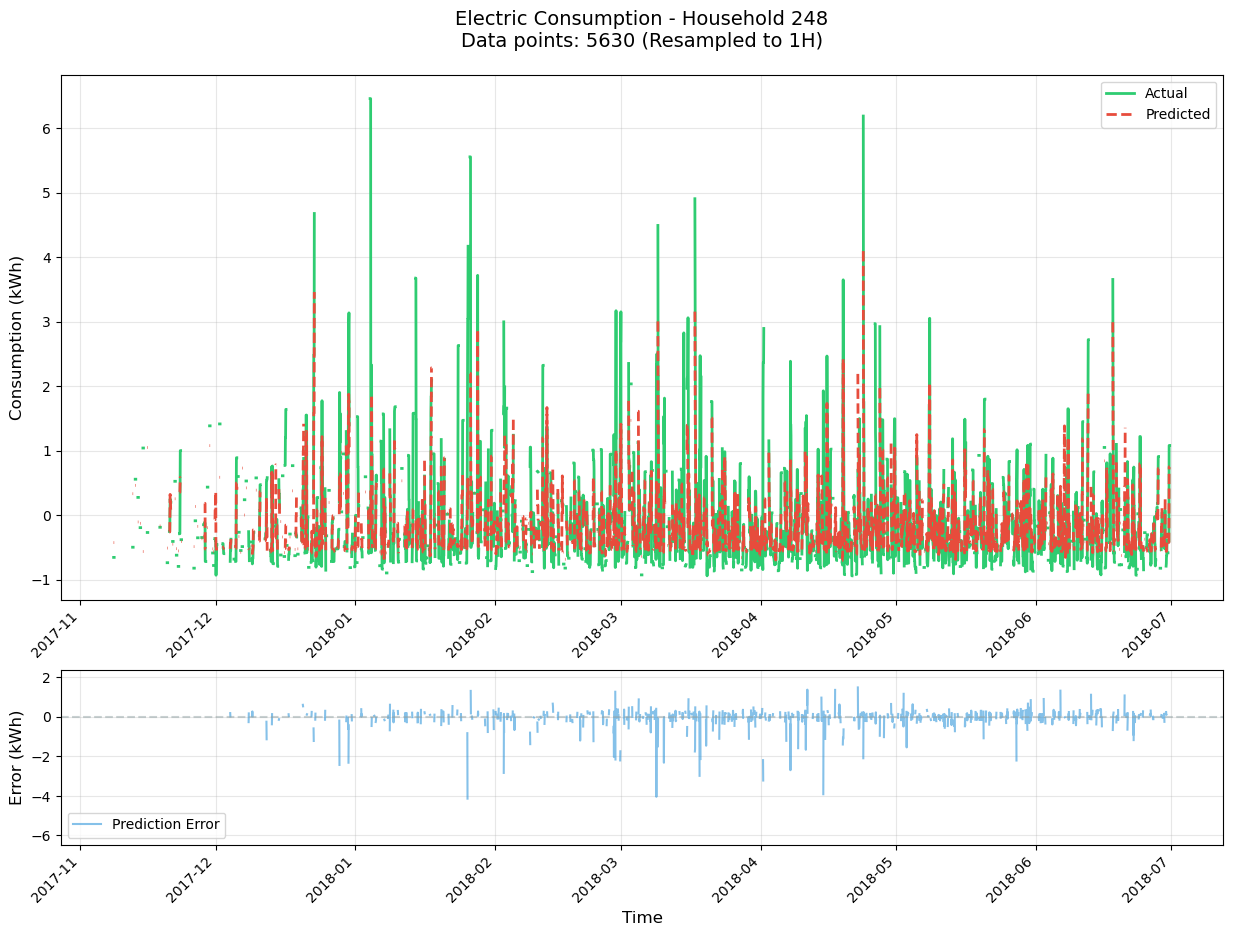

/var/folders/k4/dn8p6hf50m7bfl1db6pp0j0w0000gn/T/ipykernel_1666/1240200592.py:78: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_resampled = data.resample(resample_rule).mean()


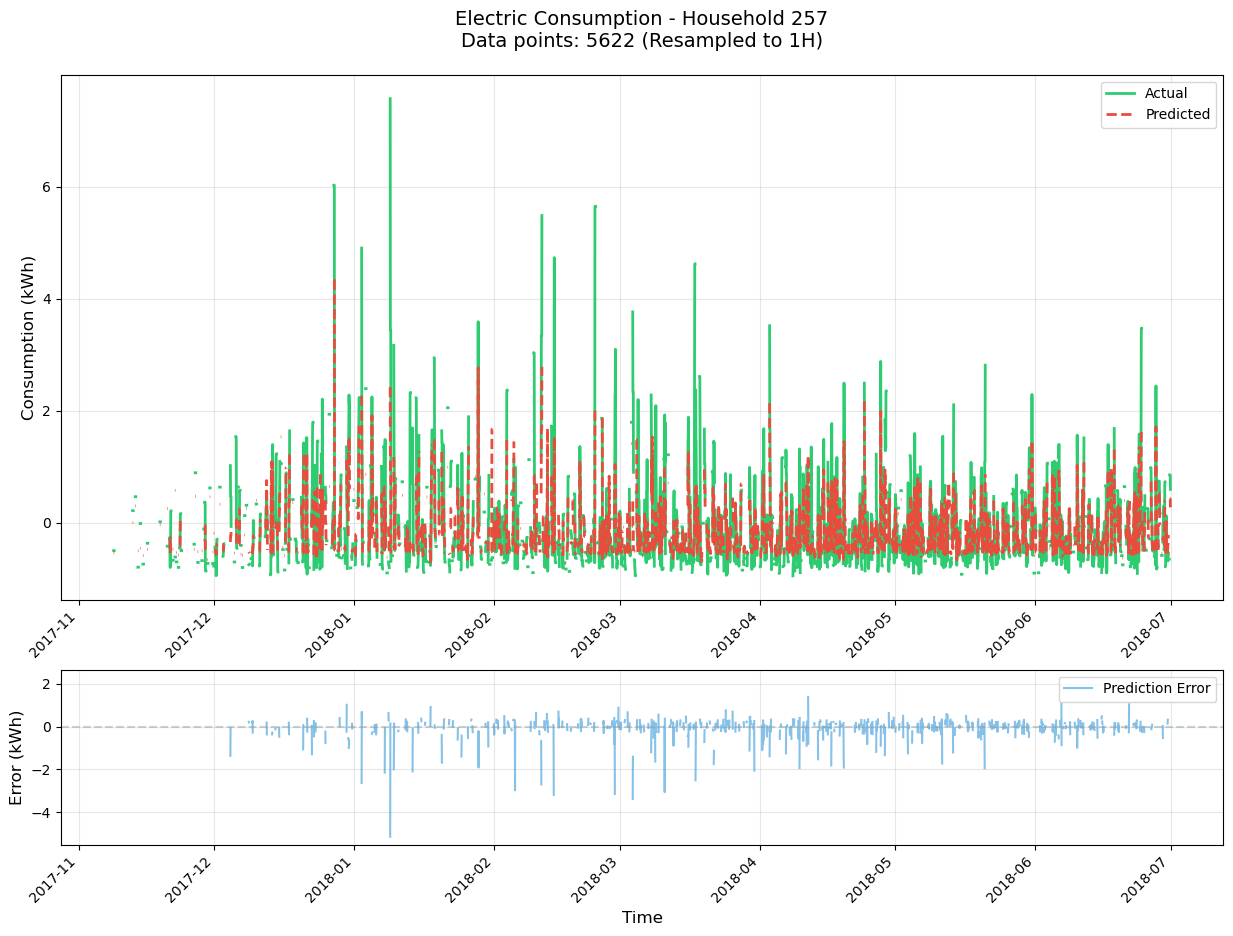

/var/folders/k4/dn8p6hf50m7bfl1db6pp0j0w0000gn/T/ipykernel_1666/1240200592.py:78: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_resampled = data.resample(resample_rule).mean()


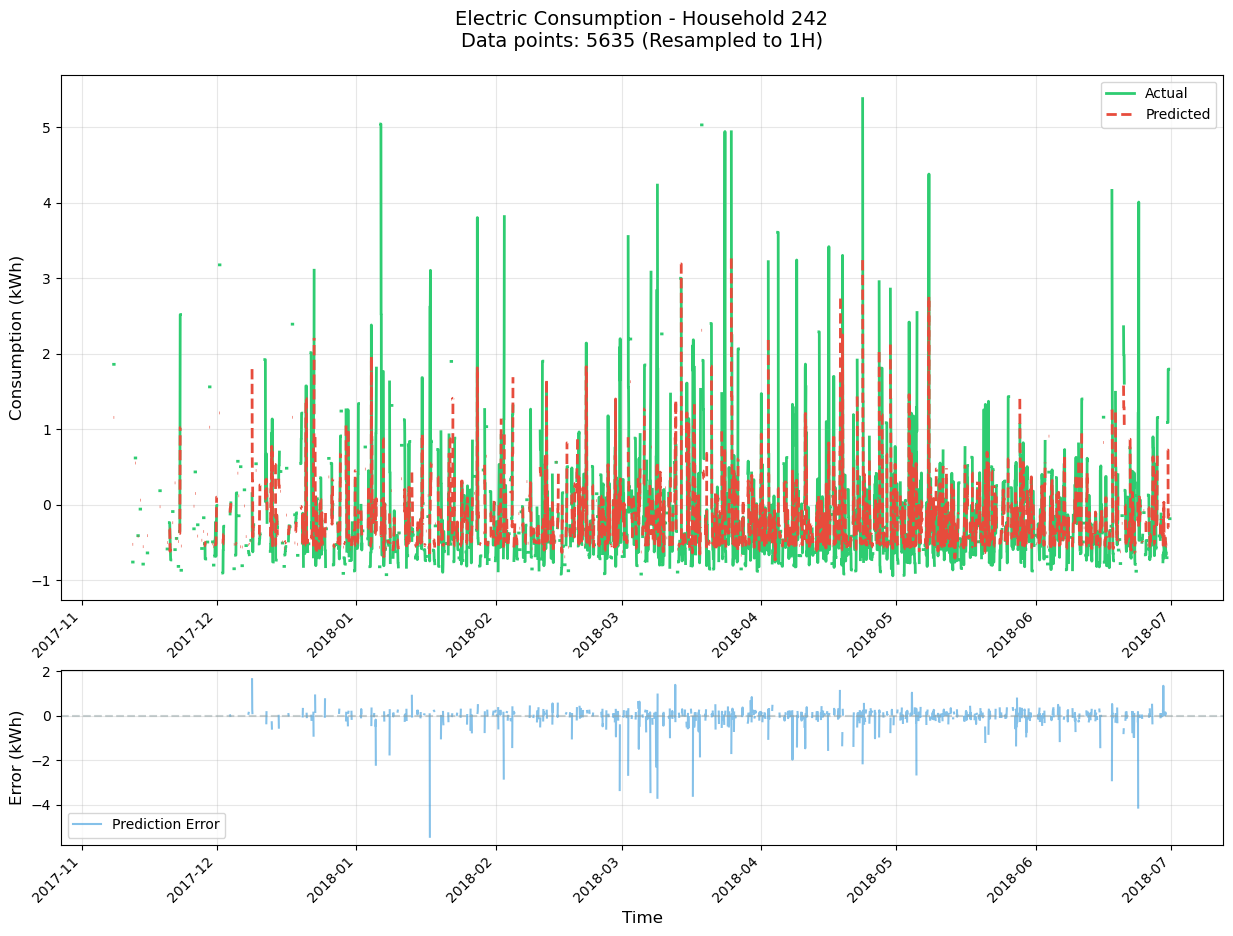

/var/folders/k4/dn8p6hf50m7bfl1db6pp0j0w0000gn/T/ipykernel_1666/1240200592.py:78: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_resampled = data.resample(resample_rule).mean()


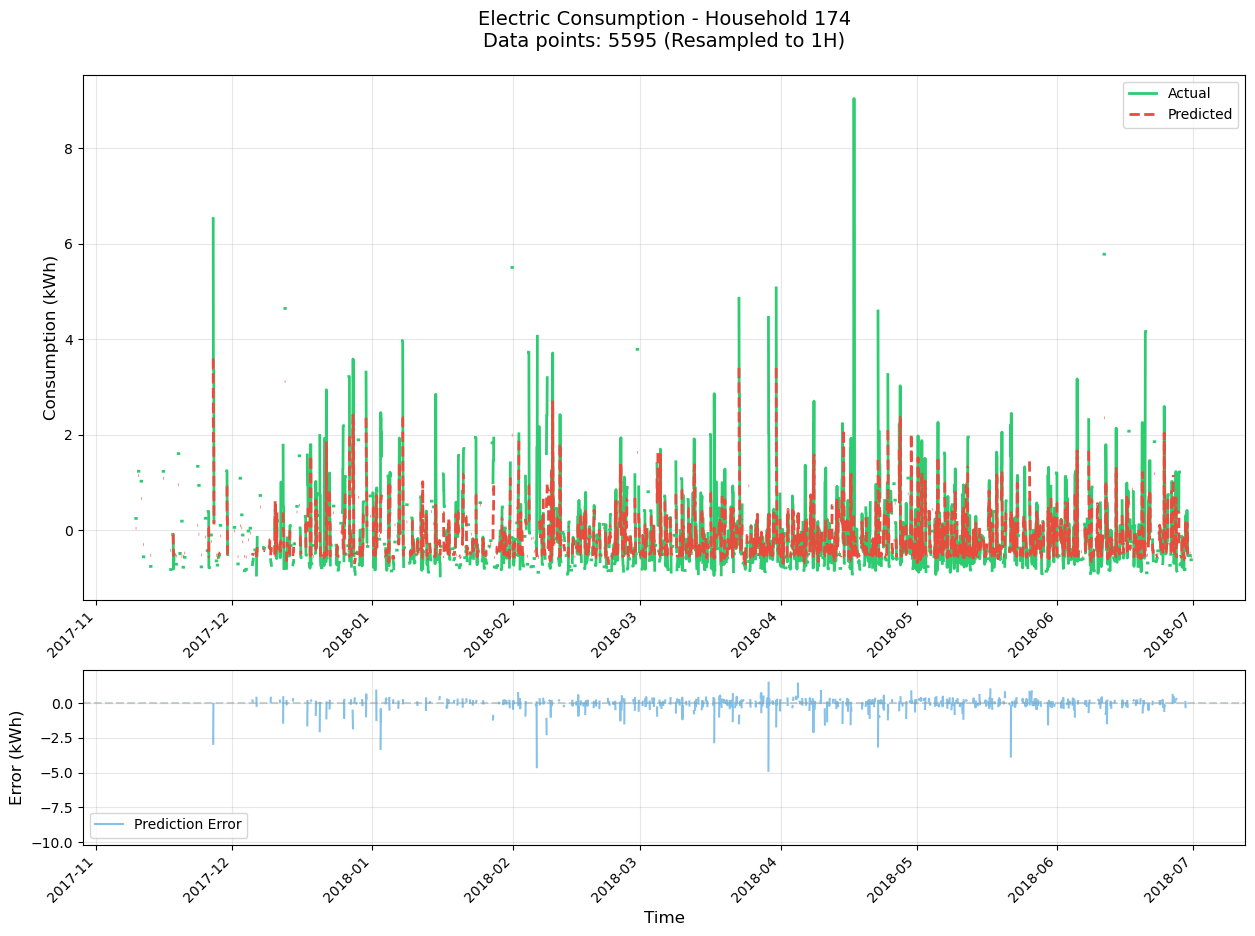

/var/folders/k4/dn8p6hf50m7bfl1db6pp0j0w0000gn/T/ipykernel_1666/1240200592.py:78: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_resampled = data.resample(resample_rule).mean()


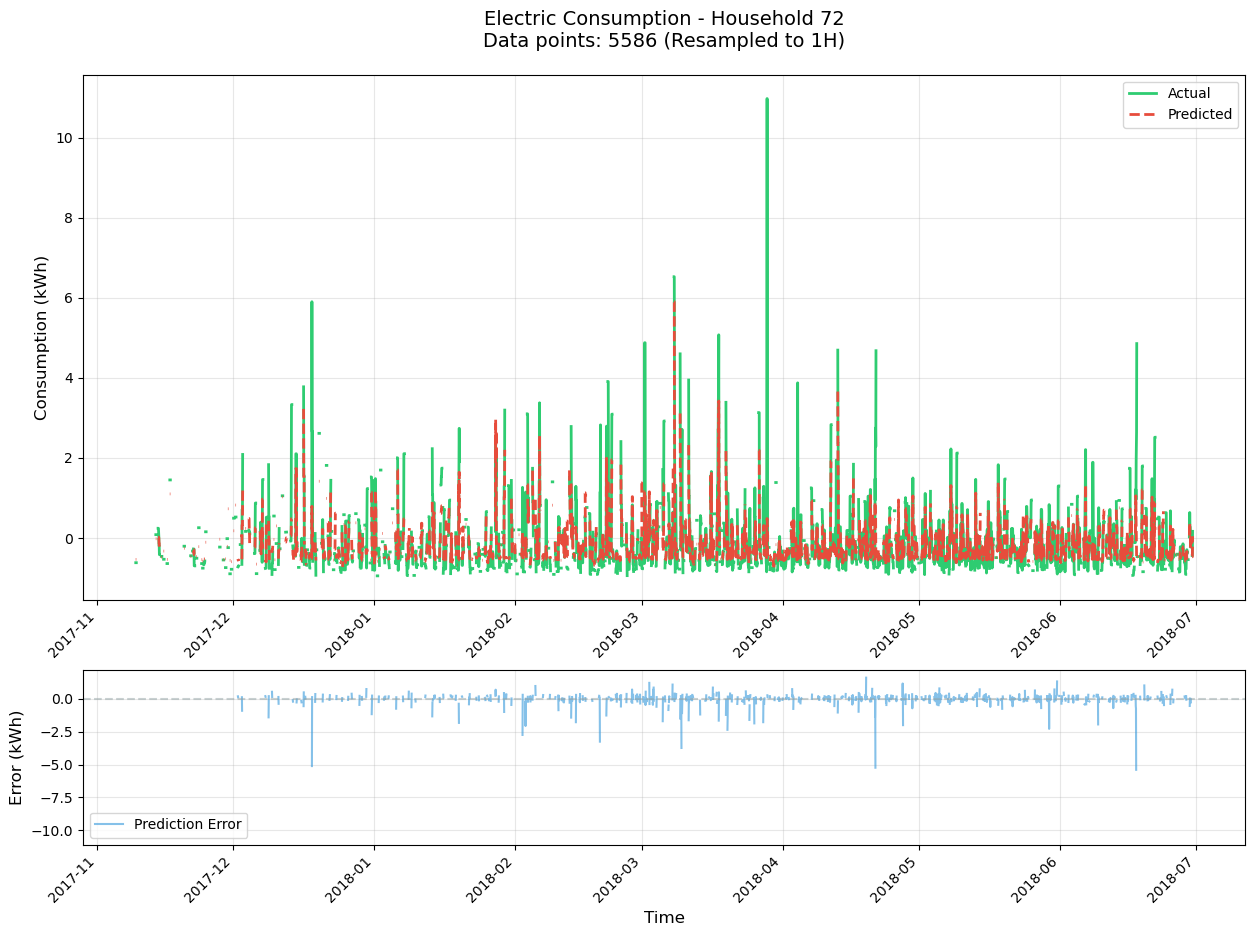

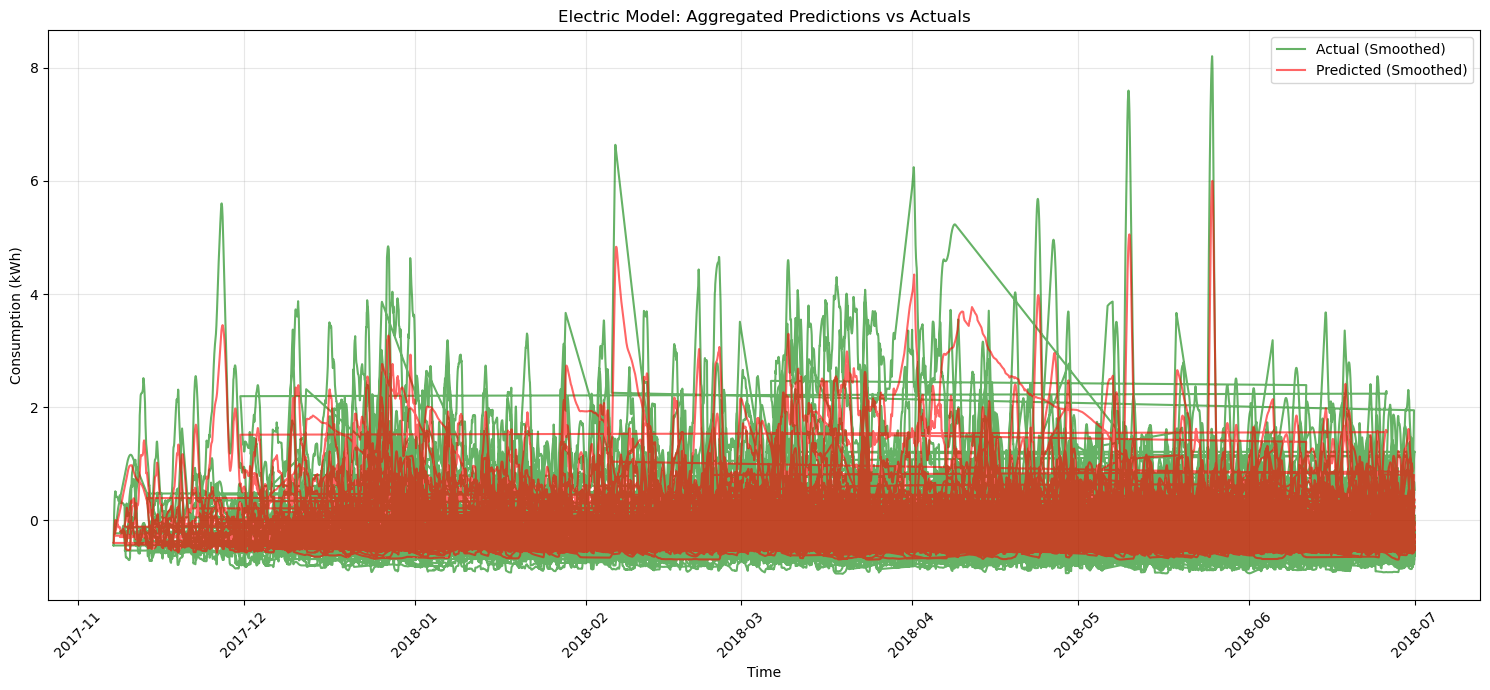

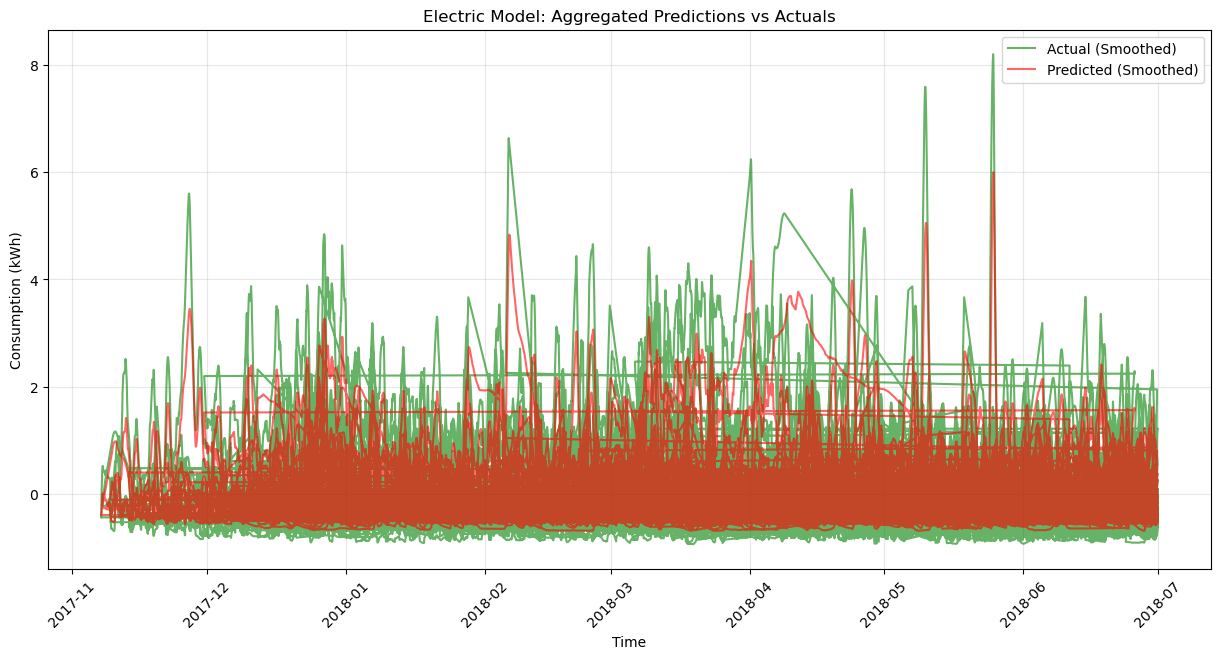

In [13]:



# Create plots
for name in results:
    plot_predictions_per_household(
        predictions=results[name]['predictions'],
        actuals=results[name]['actuals'],
        household_ids=metadata[name]['household_ids'],
        timestamps=metadata[name]['timestamps'],
        model_name=name,
        max_houses=5,
        show_plots=True
    )
    
    plt.figure(figsize=(15, 7))
    time_series = pd.to_datetime(metadata[name]['timestamps'])
    actual_series = pd.Series(results[name]['actuals'].flatten(), index=time_series)
    pred_series = pd.Series(results[name]['predictions'].flatten(), index=time_series)
    
    # Calculate rolling means with 24-hour window
    actual_smooth = actual_series.rolling(window=24, center=True, min_periods=1).mean()
    pred_smooth = pred_series.rolling(window=24, center=True, min_periods=1).mean()
    
    plt.plot(actual_smooth, label='Actual (Smoothed)', color='green', alpha=0.6)
    plt.plot(pred_smooth, label='Predicted (Smoothed)', color='red', alpha=0.6)
    
    plt.title(f'{name} Model: Aggregated Predictions vs Actuals')
    plt.xlabel('Time')
    plt.ylabel('Consumption (kWh)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    plot_predictions_aggregated(
        predictions=results[name]['predictions'],
        actuals=results[name]['actuals'],
        timestamps=metadata[name]['timestamps'],
        model_name=name,
        window_size=24,
        show_plots=True
    )